<a href="https://colab.research.google.com/github/khatgarhaastha/Sentiment_analysis_using_BERT/blob/main/Sentiment_analysis_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this notebook, I'll be exploring BERT model from Hugging Face to perform sentiment analysis on airline tweets.**

Let's begin with some initial setup before we dive into data exploration.

We will need:

1. Transformers library from Hugging Face
2. Kaggle to use their public API to download datasets

In [ ]:
!pip install kaggle
!pip install transformers

In [ ]:
# Import libraries

import random
from collections import defaultdict
import matplotlib.pyplot as plt
from textwrap import wrap
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import os

from matplotlib import rc
from pylab import rcParams
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import (
    AdamW,
    BertModel,
    BertTokenizer,
    get_linear_schedule_with_warmup,
)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
# Set color palette for plots
color = lambda: random.randint(0, 255)
colors = ['#%02X%02X%02X' %(color(), color(), color()) for i in range(6)]
sns.set_palette(sns.color_palette(colors))
rcParams['figure.figsize'] = 12, 10

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Check if cuda is enabled in the device
device = torch.cuda.is_available()

if not device:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


**DATA EXPLORATION**

I am using **US airline twitter dataset** from kaggle

In [ ]:
df = pd.read_csv("Tweets.csv")

In [ ]:
df.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


Checking the data distribution among the three classes.

The classe are:
1. Positive
2. Negative
3. Neutral

<Axes: xlabel='airline_sentiment', ylabel='count'>

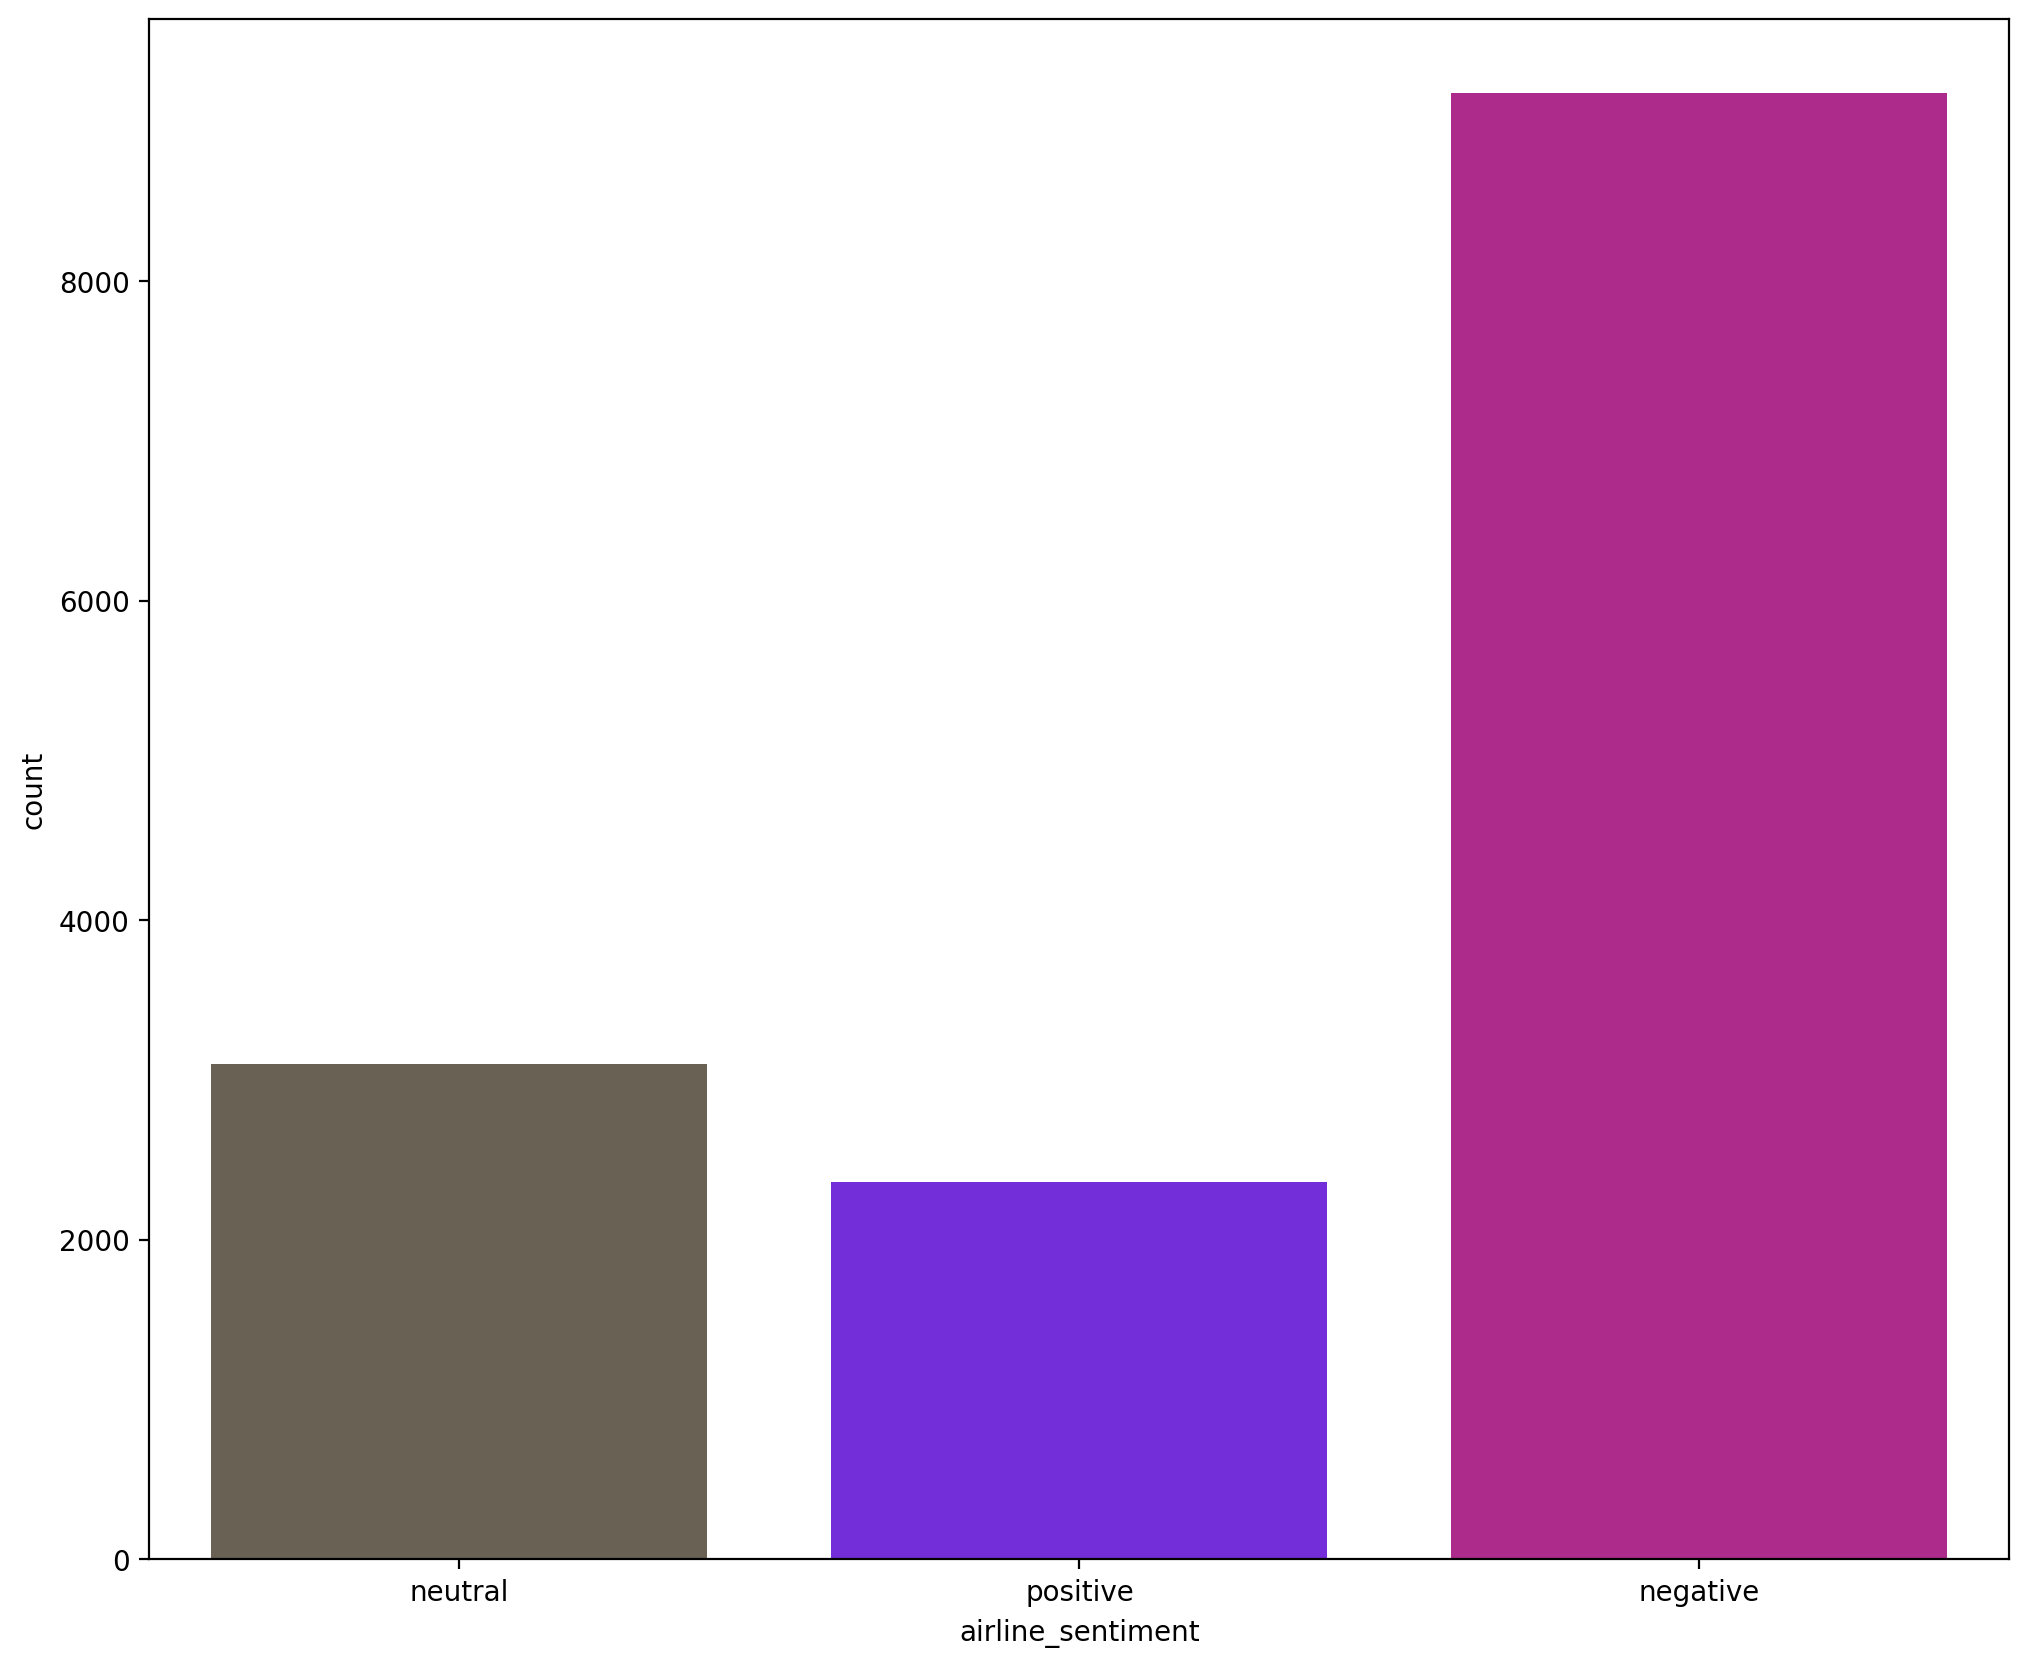

In [ ]:
sns.countplot(x=df.airline_sentiment)



1. **Sentiments Overview**:
   - **Neutral Sentiment**: This is represented by the light gray bar. The count is somewhere above 2000 but well below 4000, suggesting that a moderate number of the airline-related feedback or comments fall into this category. This means that these comments neither express positive nor negative sentiment regarding the airline.
   
   - **Positive Sentiment**: This is depicted by the red bar. The count is closer to 2000, indicating that a smaller number of people have given positive feedback or comments about the airline. This implies a certain level of satisfaction or positive experiences shared by users.

   - **Negative Sentiment**: Represented by the blue bar, this sentiment has the highest count, reaching somewhere above 8000. This suggests that a significant number of comments or feedback about the airline are negative. This indicates predominant dissatisfaction or negative experiences shared by users regarding the airline.

2. **Comparative Analysis**:
   - The **negative sentiments substantially outnumber** both the neutral and positive sentiments combined. This implies that there may be prevailing issues or challenges faced by customers that need to be addressed by the airline.
   
   - The **neutral sentiments are more frequent** than positive sentiments, but not by a very large margin. This indicates that while many users don't have a strongly positive or negative experience to share, a noticeable fraction does have positive feedback.

3. **Implications**:
   - The airline, if looking to improve customer satisfaction, should prioritize understanding and addressing the reasons behind the high number of negative comments.
   
   - The close counts of neutral and positive sentiments suggest that there's potential to convert the neutral customers into positive ones by enhancing certain aspects of the customer experience.

In summary, the graph provides a clear visual representation of sentiment distribution related to airline feedback. The airline has a challenge ahead in terms of addressing negative sentiments, but there's also potential for improvement by focusing on the neutral segment and understanding their needs.

<Axes: >

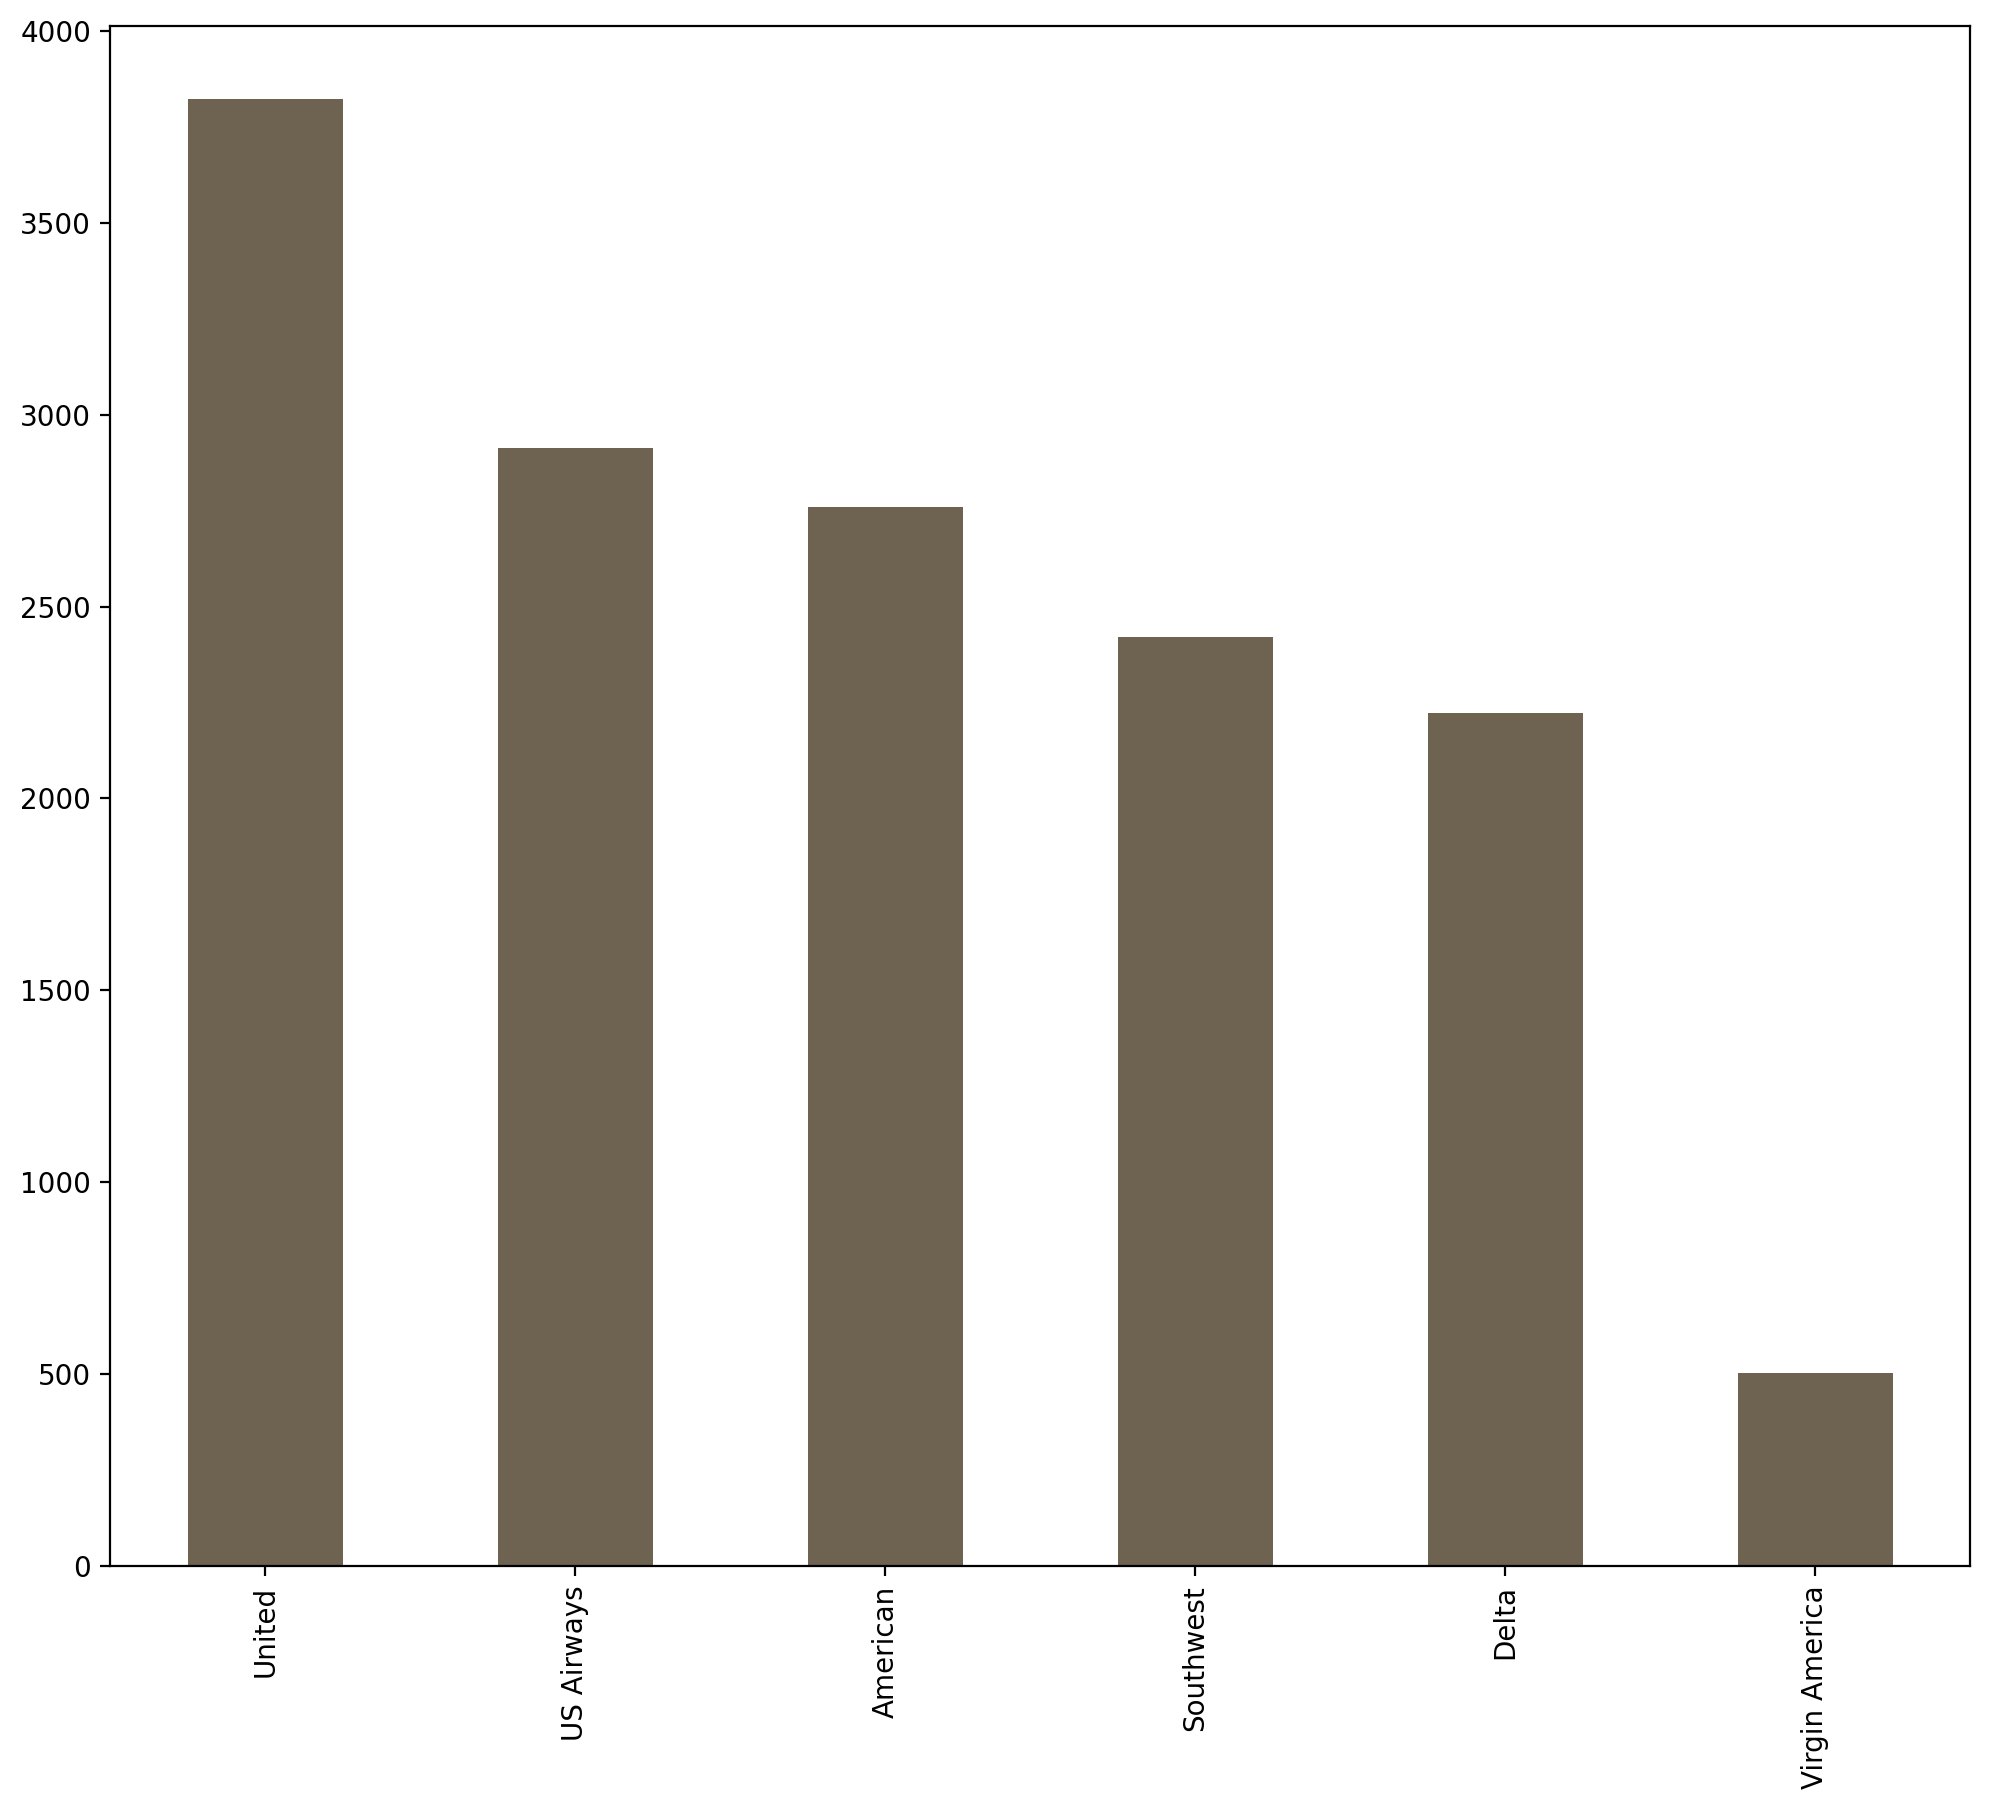

In [ ]:
df['airline'].value_counts().plot(kind='bar')

 From the graph, the following observations can be made:

1. **United** has the highest count, with its bar reaching close to 4000. This indicates that United has the maximum number of data points or occurrences among the displayed airlines.

2. **US Airways** and **American** have similar counts, with both bars extending somewhere between 2500 and 3000.

3. **Southwest** and **Delta** also have comparable counts, but they are slightly lower than US Airways and American, ranging between 2000 and 2500.

4. **Virgin America** has the lowest count among all the displayed airlines, with its bar just above 500.


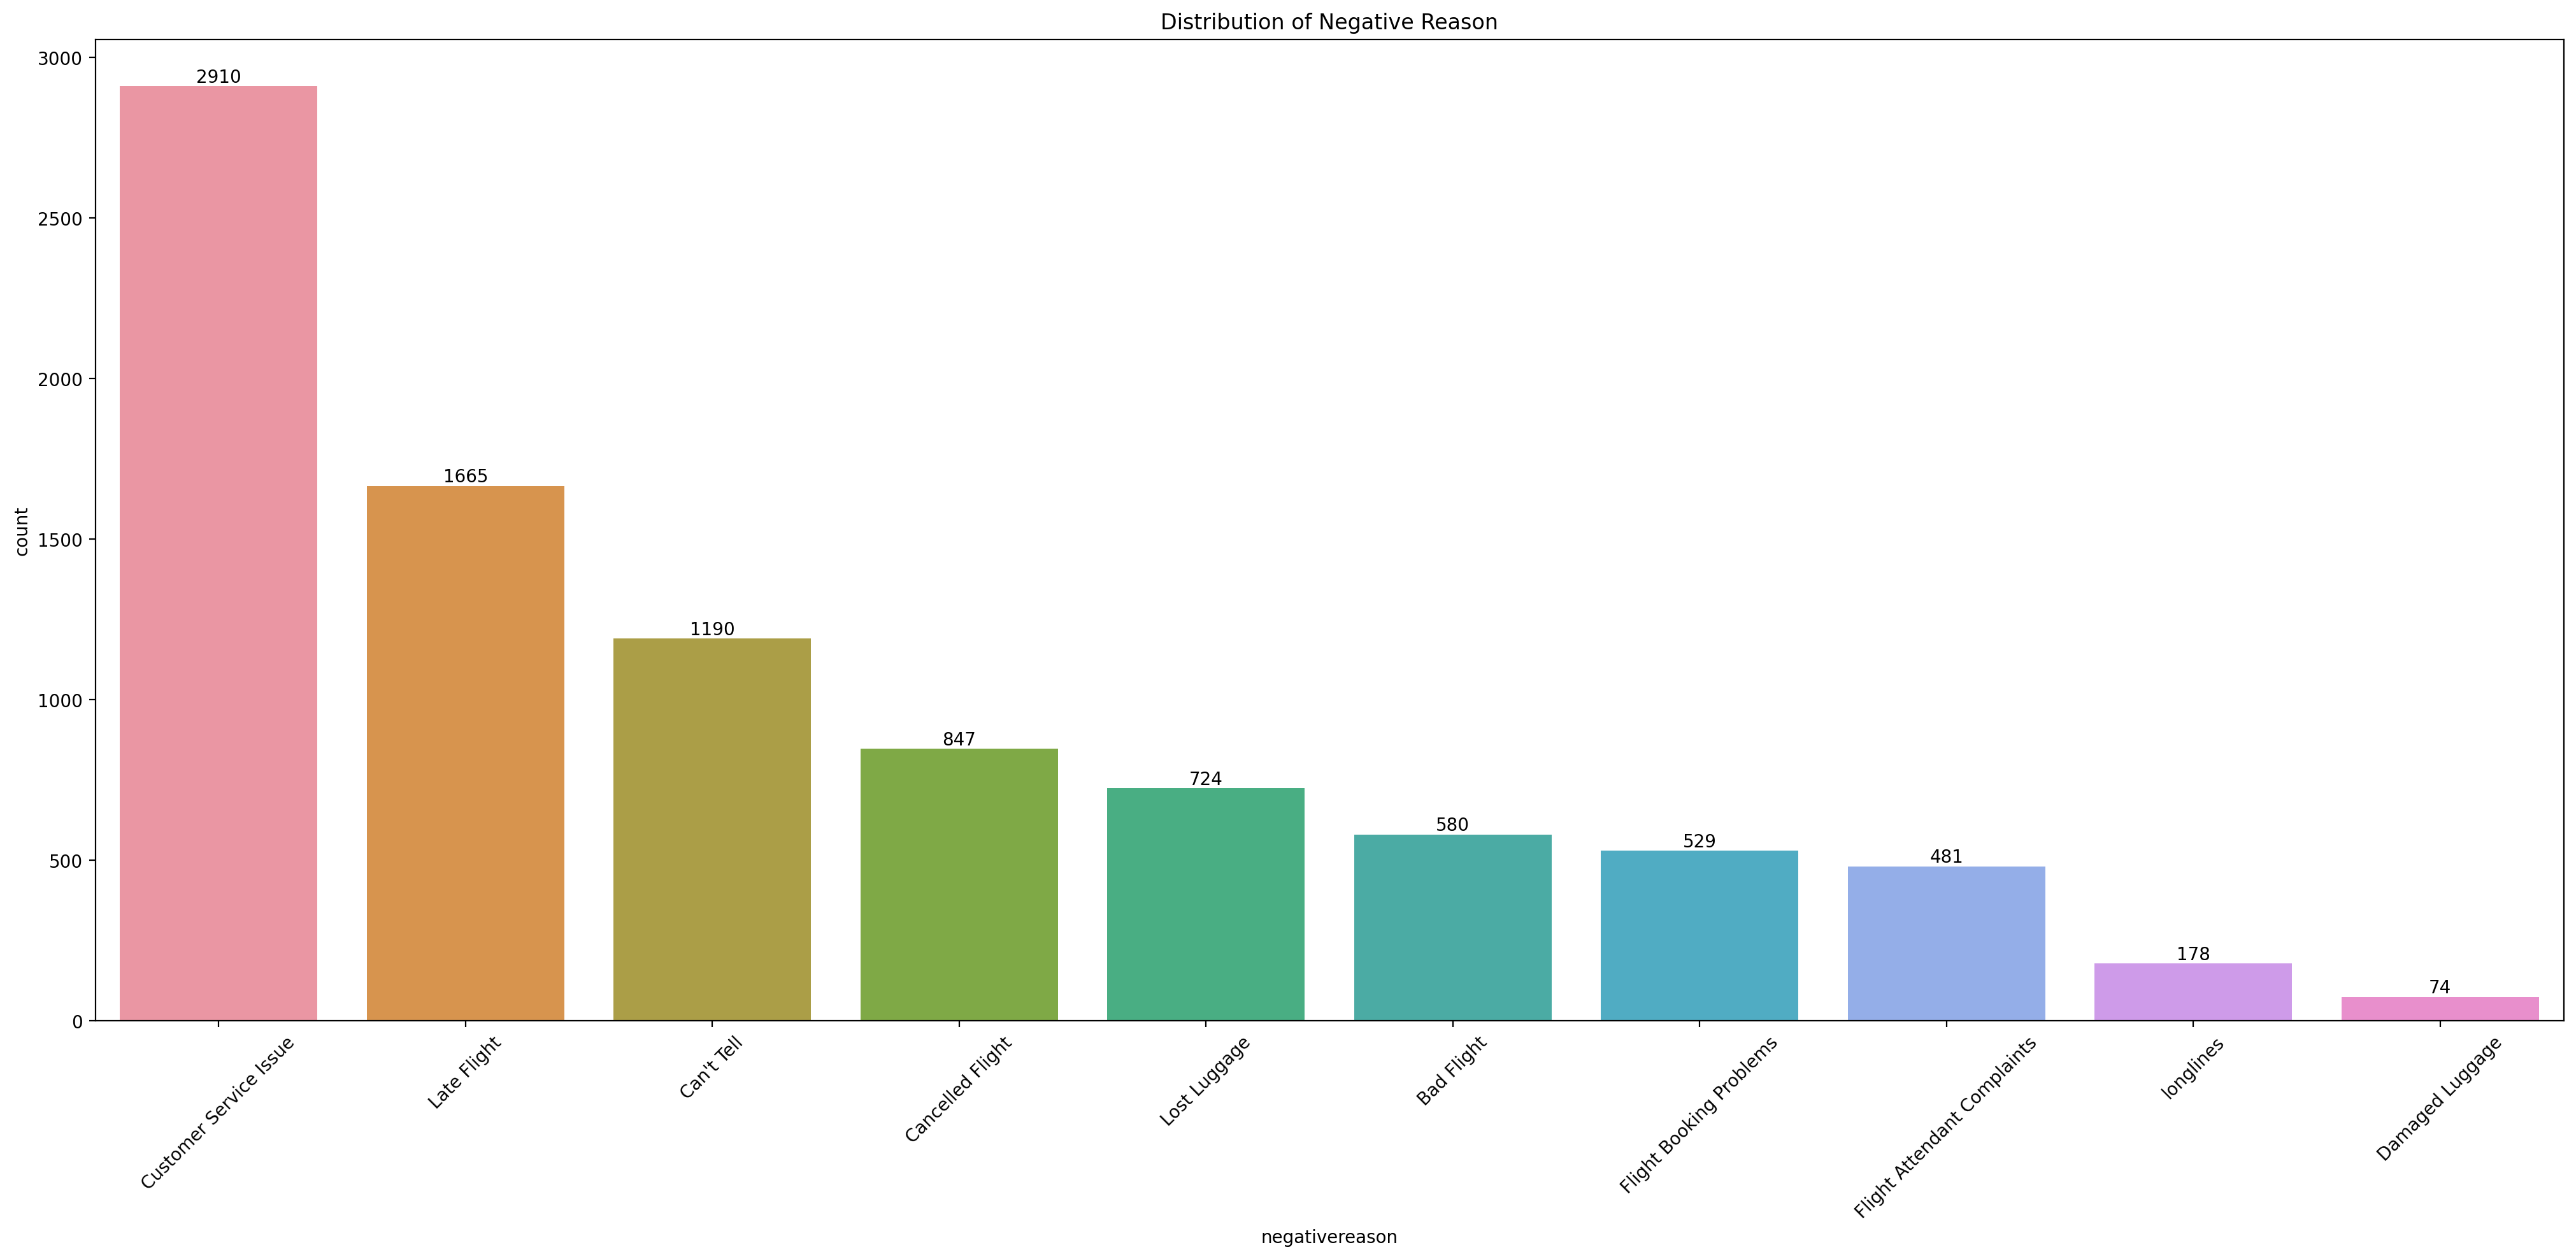

In [ ]:
plt.figure(figsize=(25,10))
order_list = df['negativereason'].value_counts().index.tolist()
ax = sns.countplot(x='negativereason', data=df, order=order_list)
ax.bar_label(ax.containers[0])
ax.set_title('Distribution of Negative Reason')
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels if they overlap
plt.show()


The bar chart depicts the distribution of various reasons for negative feedback.

1. **Customer Service Issue**: This is the most common negative reason, with a count of 2,910. The bar for this reason stands significantly taller than the others, indicating a prominent issue.

2. **Late Flight**: The second most common negative reason with a count of 1,665.

3. **Can't Tell**: This reason, which might indicate ambiguous or unspecified complaints, comes in third with a count of 1,190.

4. **Canceled Flight**: There were 847 complaints related to flight cancellations.

5. **Lost Luggage**: 724 instances where lost luggage was the primary grievance.

6. **Bad Flight**: A total of 580 passengers had general complaints about the flight being bad.

7. **Flight Booking Problems**: There were 529 complaints related to issues with flight bookings.

8. **Flight Attendant Complaints**: This category has 481 complaints, which might pertain to behavior or service quality of the flight attendants.

9. **Longlines**: 178 passengers complained about long lines, possibly at check-in counters, boarding gates, or security checks.

10. **Damaged Luggage**: The least common negative reason, with a count of 74, relates to luggage that was damaged during transit.

In summary, the **most prevalent issues are related to customer service and late flights, with these two categories combining for over 4,500 complaints**. Other issues, such as damaged luggage, are much less common but still noteworthy. The data provides valuable insights for airlines or aviation service providers to understand where they might need to focus their improvement efforts.

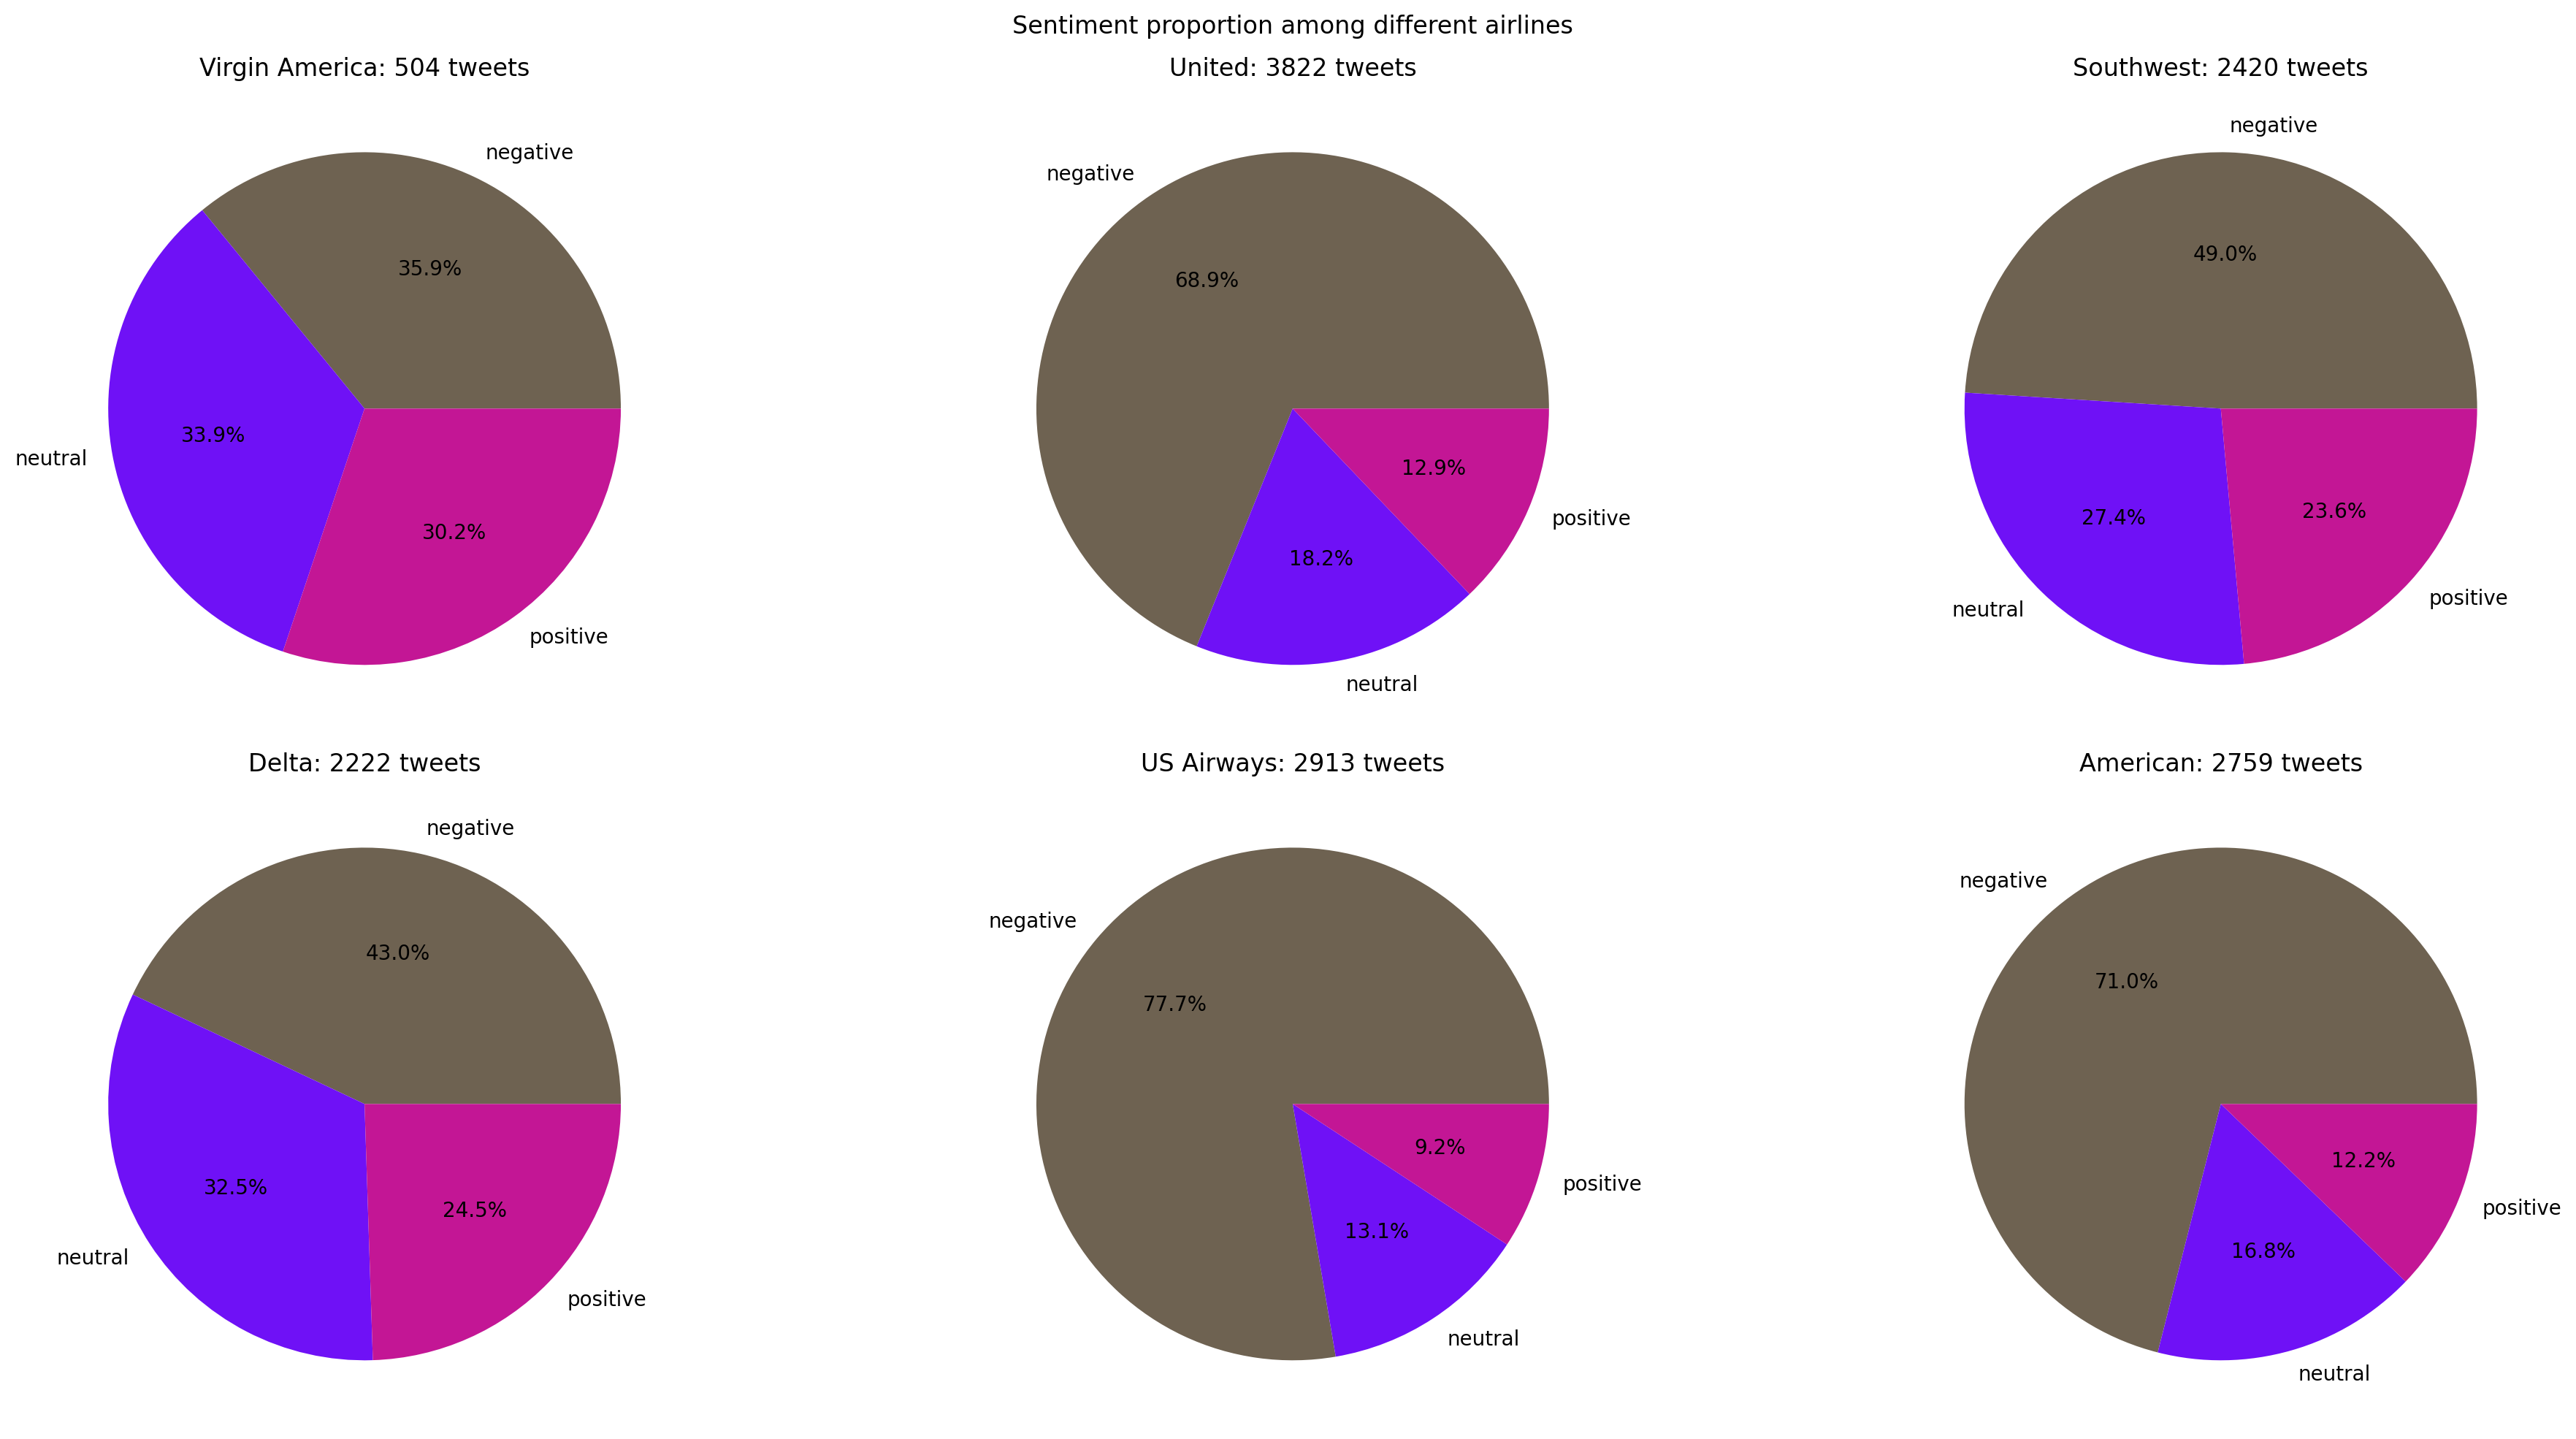

In [ ]:
data = df.groupby(['airline', 'airline_sentiment'])['airline_sentiment'].count().unstack()
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

# Use enumerate to get both index and the airline name
for idx, airline in enumerate(df['airline'].unique()):
    ax = axes[idx]
    ax.pie(data.loc[airline], labels=data.columns, autopct='%1.1f%%')
    ax.set_title(f"{airline}: {data.loc[airline].sum()} tweets")

plt.suptitle('Sentiment proportion among different airlines')
plt.tight_layout()
plt.show()


The pie charts depict the sentiment proportions for various airlines based on the number of tweets received.

1. **Virgin America (504 tweets):**
   Virgin America has a **fairly even distribution of sentiments**, with only a slightly higher proportion of negative tweets.

2. **Delta (22,222 tweets):**
   Delta has a **higher proportion of negative sentiments** but still maintains a sizable chunk of neutral and positive feedback.

3. **United (3,822 tweets):**
   United sees a **predominantly negative sentiment**, with almost 70% of the tweets being negative.

4. **Southwest (2,420 tweets):**
   Southwest has **almost half of its feedback as negative**, but the positive sentiment is not far behind the neutral sentiment.

5. **US Airways (2,913 tweets):**
   US Airways has the **most skewed distribution** with a whopping 77.7% of tweets being negative.

6. **American (2,759 tweets):**
   American Airlines also witnesses a **high negative sentiment at 71%**, with the other sentiments trailing behind.

In summary, while **Virgin America and Delta have a more balanced sentiment** distribution among the tweets, airlines like **United, US Airways, and American are heavily skewed towards negative sentiments**.

**DATA PREPROCESSING**

In [ ]:
# The pre_processing function takes a DataFrame and cleans the text within its text column by removing URLs and mentions.

import re
def pre_processing(df):
    df['text'] = df['text'].apply(lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', x))
    df['text'] = df['text'].apply(lambda x: re.sub('(@[A-Za-z0-9_]+)','', x))

In [ ]:
# The code snippet cleans the text data in the df DataFrame and
# then encodes the textual sentiment labels into numerical IDs for easier processing and modeling later on.

# Light cleanup before tokenization
pre_processing(df)

# Encode labels
possible_labels = df.airline_sentiment.unique()
labels_map = {possible_labels[idx]: idx for idx, label in enumerate(possible_labels)}
df['labels'] = df.airline_sentiment.replace(labels_map)

The following code is initializing a tokenizer for the base version of the BERT model, which has been trained on lowercase (or "uncased") text. This tokenizer will be used to convert raw text into a format that's suitable for input into the BERT model for further processing or fine-tuning.

**Tokenization** is the process of breaking down text into smaller pieces, called tokens. These tokens can be as small as characters or as long as words.This is important because machines don’t understand text the way humans do. They need text to be broken down into pieces that can be analyzed and processed.

**Padding** is adding extra, non-informative tokens to a sequence to make it as long as the longest sequence in a batch. Models often require that all text data be the same length. If one piece of text is shorter than another, padding helps equalize the lengths.

An **attention mask** is a way to tell the model which tokens are actual words and which tokens are padding. This is crucial because we don’t want the model to waste time or get confused by the padding tokens.

In [ ]:
MODEL = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL, do_lower_case=True)

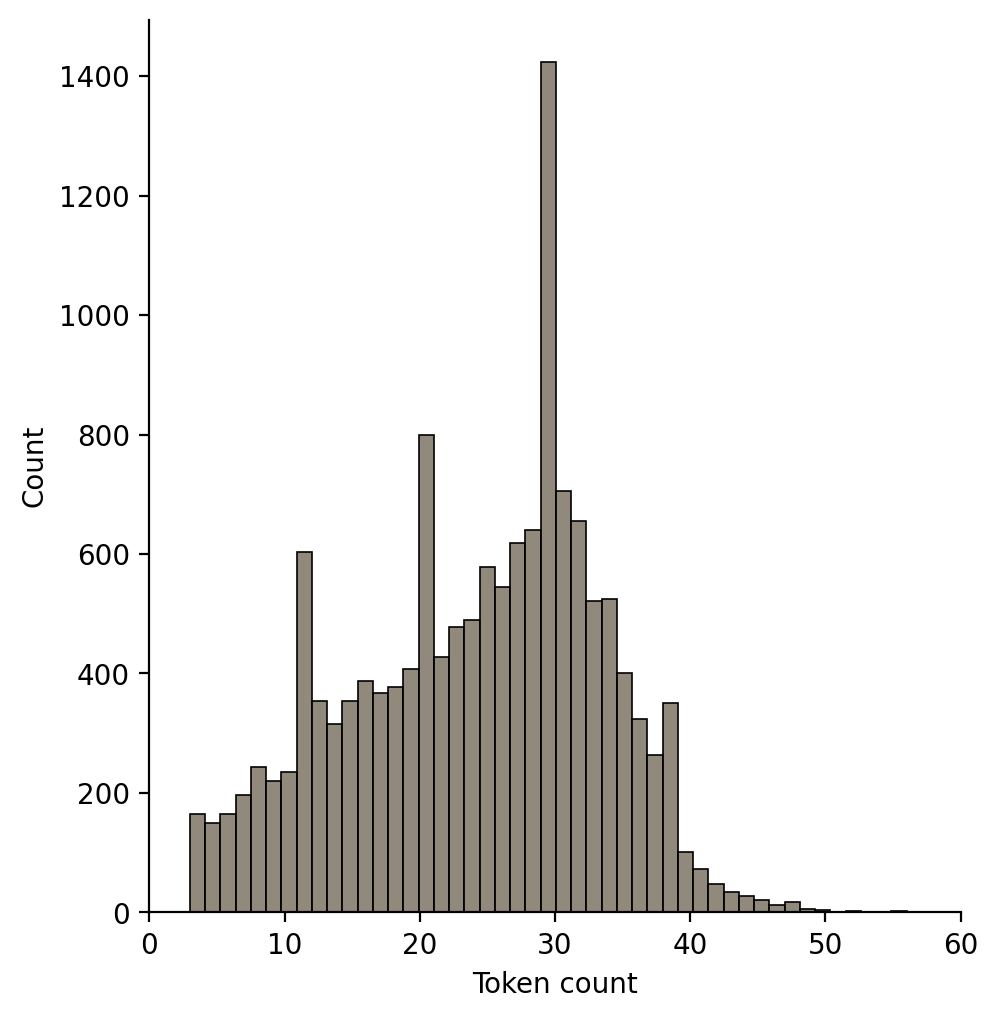

In [ ]:
# The code is analyzing the distribution of token counts (number of tokens) in a dataset when tokenized using the BERT tokenizer.
# It helps to understand the typical sequence lengths, which can be useful when setting parameters for training or fine-tuning a BERT model on this dataset.

tokens = [len(tokenizer.encode(text, max_length=512, truncation=True)) for text in df.text]
sns.displot(tokens)
plt.xlim([0, 60]);
plt.xlabel('Token count');


**X-Axis (Token count)**: Represents the number of tokens in each piece of text after being tokenized. The tokens range from near 0 up to around 60.

**Y-Axis (Count)**: Represents the number of texts (or samples) that fall into each token count bin.

This CustomDataset class is a structured way to handle, organize, and process tweet data for use in a PyTorch model, making it suitable for tasks like text classification, sentiment analysis, etc. This custom dataset can then be used with a DataLoader to efficiently batch and shuffle the data during training or evaluation of a machine learning model.

In [ ]:
# This code defines a custom PyTorch dataset for the sentiment analysis task using BERT.
# This code provides a custom way to handle the dataset by converting raw text data into a format ready for BERT training.
# When we use a DataLoader with this CustomDataset, it will allow us to easily fetch batches of processed data during training.

from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):

    def __init__(
        self,
        tweets,
        labels,
        tokenizer,
        max_length
    ):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        label = self.labels[idx]

        tokenize = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'tweet': tweet,
            'input_ids': tokenize['input_ids'].flatten(),
            'attention_mask': tokenize['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long)
               }

In [ ]:
# This code sets up the data preparation and loading process for training, validation, and testing a sentiment analysis
# model using the custom dataset tailored for BERT
# It splits the data into appropriate subsets, converts these subsets into a format suitable for BERT,
# and then creates loaders that allow efficient batch-wise iteration over these processed


MAX_LENGTH = 64
TEST_SIZE = 0.1
VALID_SIZE = 0.5
BATCH_SIZE = 16
NUM_WORKERS = 2

train_sampler, test_sampler = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)
valid_sampler, test_sampler = train_test_split(test_sampler, test_size=VALID_SIZE, random_state=RANDOM_STATE)

train_set = CustomDataset(
    train_sampler['text'].to_numpy(),
    train_sampler['labels'].to_numpy(),
    tokenizer,
    MAX_LENGTH
)
test_set = CustomDataset(
    test_sampler['text'].to_numpy(),
    test_sampler['labels'].to_numpy(),
    tokenizer,
    MAX_LENGTH
)
valid_set = CustomDataset(
    valid_sampler['text'].to_numpy(),
    valid_sampler['labels'].to_numpy(),
    tokenizer,
    MAX_LENGTH
)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

AirlineSentimentClassifier is a custom classifier that utilizes a pre-trained BERT model for feature extraction from text data, applies dropout for regularization, and uses a linear classifier to predict the sentiment of airline reviews. During the forward pass, input data is passed through the BERT model, followed by the dropout and classification layers, and the sentiment predictions are returned.

In [ ]:
# This code defines a PyTorch neural network model specifically tailored for the task of sentiment classification, leveraging the pre-trained BERT model.
# When this AirlineSentimentClassifier model is provided with tokenized text data (as input_ids and attention_mask), it will produce logits corresponding to the sentiment classes.
# These logits can then be further processed (e.g., with a softmax function) to get probabilities for each class.


from torch import nn
class AirlineSentimentClassifier(nn.Module):

    def __init__(self, num_labels):
        super (AirlineSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL)
        self.dropout = nn.Dropout(p=0.2)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        out = self.classifier(pooled_output)
        return out

In [ ]:
# Initializing the AirlineSentimentClassifier model and potentially moves it to a GPU for efficient computation

model = AirlineSentimentClassifier(len(labels_map))
print(model)

# Move tensors to GPU on CUDA enables devices
if device:
    model.cuda()

AirlineSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

**LOSS FUNCTION OPTIMIZER**

Let's define a loss function and optimizer. We will be using Categorial Cross-Entropy loss and AdamW optimizer (since it implements weight decay fix to coventional Adam algorithm) by Hugging Face.

In [ ]:
# This block sets up crucial components for training:
# hyperparameters, the loss function to measure prediction errors,
# the optimizer to update the model parameters based on the loss, and a learning rate scheduler to adjust the learning rate during training.

n_epochs = 10
learning_rate =2e-5

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False)

# Define scheduler
training_steps = len(train_loader)*n_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=training_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**TRAINING**

In [ ]:
# Track changes in validation loss
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):

    # Setting training and validation loss
    train_loss = []
    validation_loss = []
    tr_predictions = 0
    acc = 0
    val_predictions = 0

    ####################
    #  Train the model #
    ####################
    model = model.train()
    for data in train_loader:

        # Moving tensors to GPU on CUDA enabled devices
        if device:
            input_ids, attention_mask, targets = data["input_ids"].cuda(), data["attention_mask"].cuda(), data["targets"].cuda()
        # Clear the gradients of variables
        optimizer.zero_grad()

        #### Forward pass
        # Pass input through the model
        output = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Compute batch loss
        loss = criterion(output, targets)
        # Convert output probabilities to class probabilities
        _, pred = torch.max(output, 1)
        # Track correct predictions
        tr_predictions += torch.sum(pred == targets)

        #### Backward Pass
        # Compute gradients wrt to model parameters
        loss.backward()
        # To avoid exploding gradients, we clip the gradients of the model
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # Perform parameter update
        optimizer.step()
        # Update learning rate
        scheduler.step()
        # Update loss per mini bbatches
        train_loss.append(loss.item())

    ######################
    # Validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data in valid_loader:

            # Moving tensors to GPU on CUDA enabled devices
            if device:
                input_ids, attention_mask, targets = data["input_ids"].cuda(), data["attention_mask"].cuda(), data["targets"].cuda()

            #### Forward pass
            # Pass input through the model
            output = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            # Compute batch loss
            loss = criterion(output, targets)
            # Convert output probabilities to class probabilities
            _, pred = torch.max(output, 1)
            # Update loss per mini batches
            validation_loss.append(loss.item())
            # Track correct predictions
            val_predictions += torch.sum(pred == targets)

    # Compute accuracy
    train_accuracy = tr_predictions.double()/len(train_sampler)
    val_accuracy = val_predictions.double()/len(valid_sampler)

    # Print loss statistics
    print('Epoch: {}/{} \n\tTraining Loss: {:.6f} \n\tValidation Loss: {:.6f} \n\tTrain Accuracy: {:.6f} \n\tVal Accuracy: {:.6f}'.format(epoch,n_epochs, np.mean(train_loss), np.mean(validation_loss), train_accuracy, val_accuracy))

    # Save model if validation loss is decreased
    if val_accuracy > acc:
        print('Saving model...')
        torch.save(model.state_dict(), 'bert_base_fine_tuned.pt')
        acc = val_accuracy




Epoch: 1/10 
	Training Loss: 0.470403 
	Validation Loss: 0.435801 
	Train Accuracy: 0.819369 
	Val Accuracy: 0.841530
Saving model...
Epoch: 2/10 
	Training Loss: 0.254828 
	Validation Loss: 0.473941 
	Train Accuracy: 0.913100 
	Val Accuracy: 0.844262
Saving model...
Epoch: 3/10 
	Training Loss: 0.144704 
	Validation Loss: 0.679809 
	Train Accuracy: 0.959092 
	Val Accuracy: 0.851093
Saving model...
Epoch: 4/10 
	Training Loss: 0.090065 
	Validation Loss: 0.816944 
	Train Accuracy: 0.976700 
	Val Accuracy: 0.842896
Saving model...
Epoch: 5/10 
	Training Loss: 0.064664 
	Validation Loss: 0.984560 
	Train Accuracy: 0.984897 
	Val Accuracy: 0.827869
Saving model...
Epoch: 6/10 
	Training Loss: 0.045218 
	Validation Loss: 1.066963 
	Train Accuracy: 0.989299 
	Val Accuracy: 0.838798
Saving model...
Epoch: 7/10 
	Training Loss: 0.032872 
	Validation Loss: 1.115750 
	Train Accuracy: 0.992107 
	Val Accuracy: 0.845628
Saving model...
Epoch: 8/10 
	Training Loss: 0.025802 
	Validation Loss: 1.116

Let's define some metrics and see how the model performs on unseen data.

In [ ]:
# Track test loss
test_loss = 0.0
class_predictions = list(0. for i in range(3))
class_total = list(0. for i in range(3))
predictions = []
labels = []

model.eval()
with torch.no_grad():
    for data in test_loader:

        # Moving tensors to GPU on CUDA enabled devices
        if device:
            input_ids, attention_mask, targets = data["input_ids"].cuda(), data["attention_mask"].cuda(), data["targets"].cuda()

        #### Forward pass
        # Pass input through the model
        output = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Compute batch loss
        loss = criterion(output, targets)
        # Update loss
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)

        predictions.extend(pred)
        labels.extend(targets)

predictions = torch.stack(predictions) if not device else torch.stack(predictions).cpu()
labels = torch.stack(labels) if not device else torch.stack(labels).cpu()

In [ ]:
print(classification_report(predictions, labels, target_names=['neutral', 'positive','negative']))

              precision    recall  f1-score   support

     neutral       0.69      0.72      0.70       146
    positive       0.78      0.81      0.79       118
    negative       0.92      0.90      0.91       468

    accuracy                           0.85       732
   macro avg       0.80      0.81      0.80       732
weighted avg       0.85      0.85      0.85       732



**Visualization**

Text(120.72222222222221, 0.5, 'Predicted sentiment')

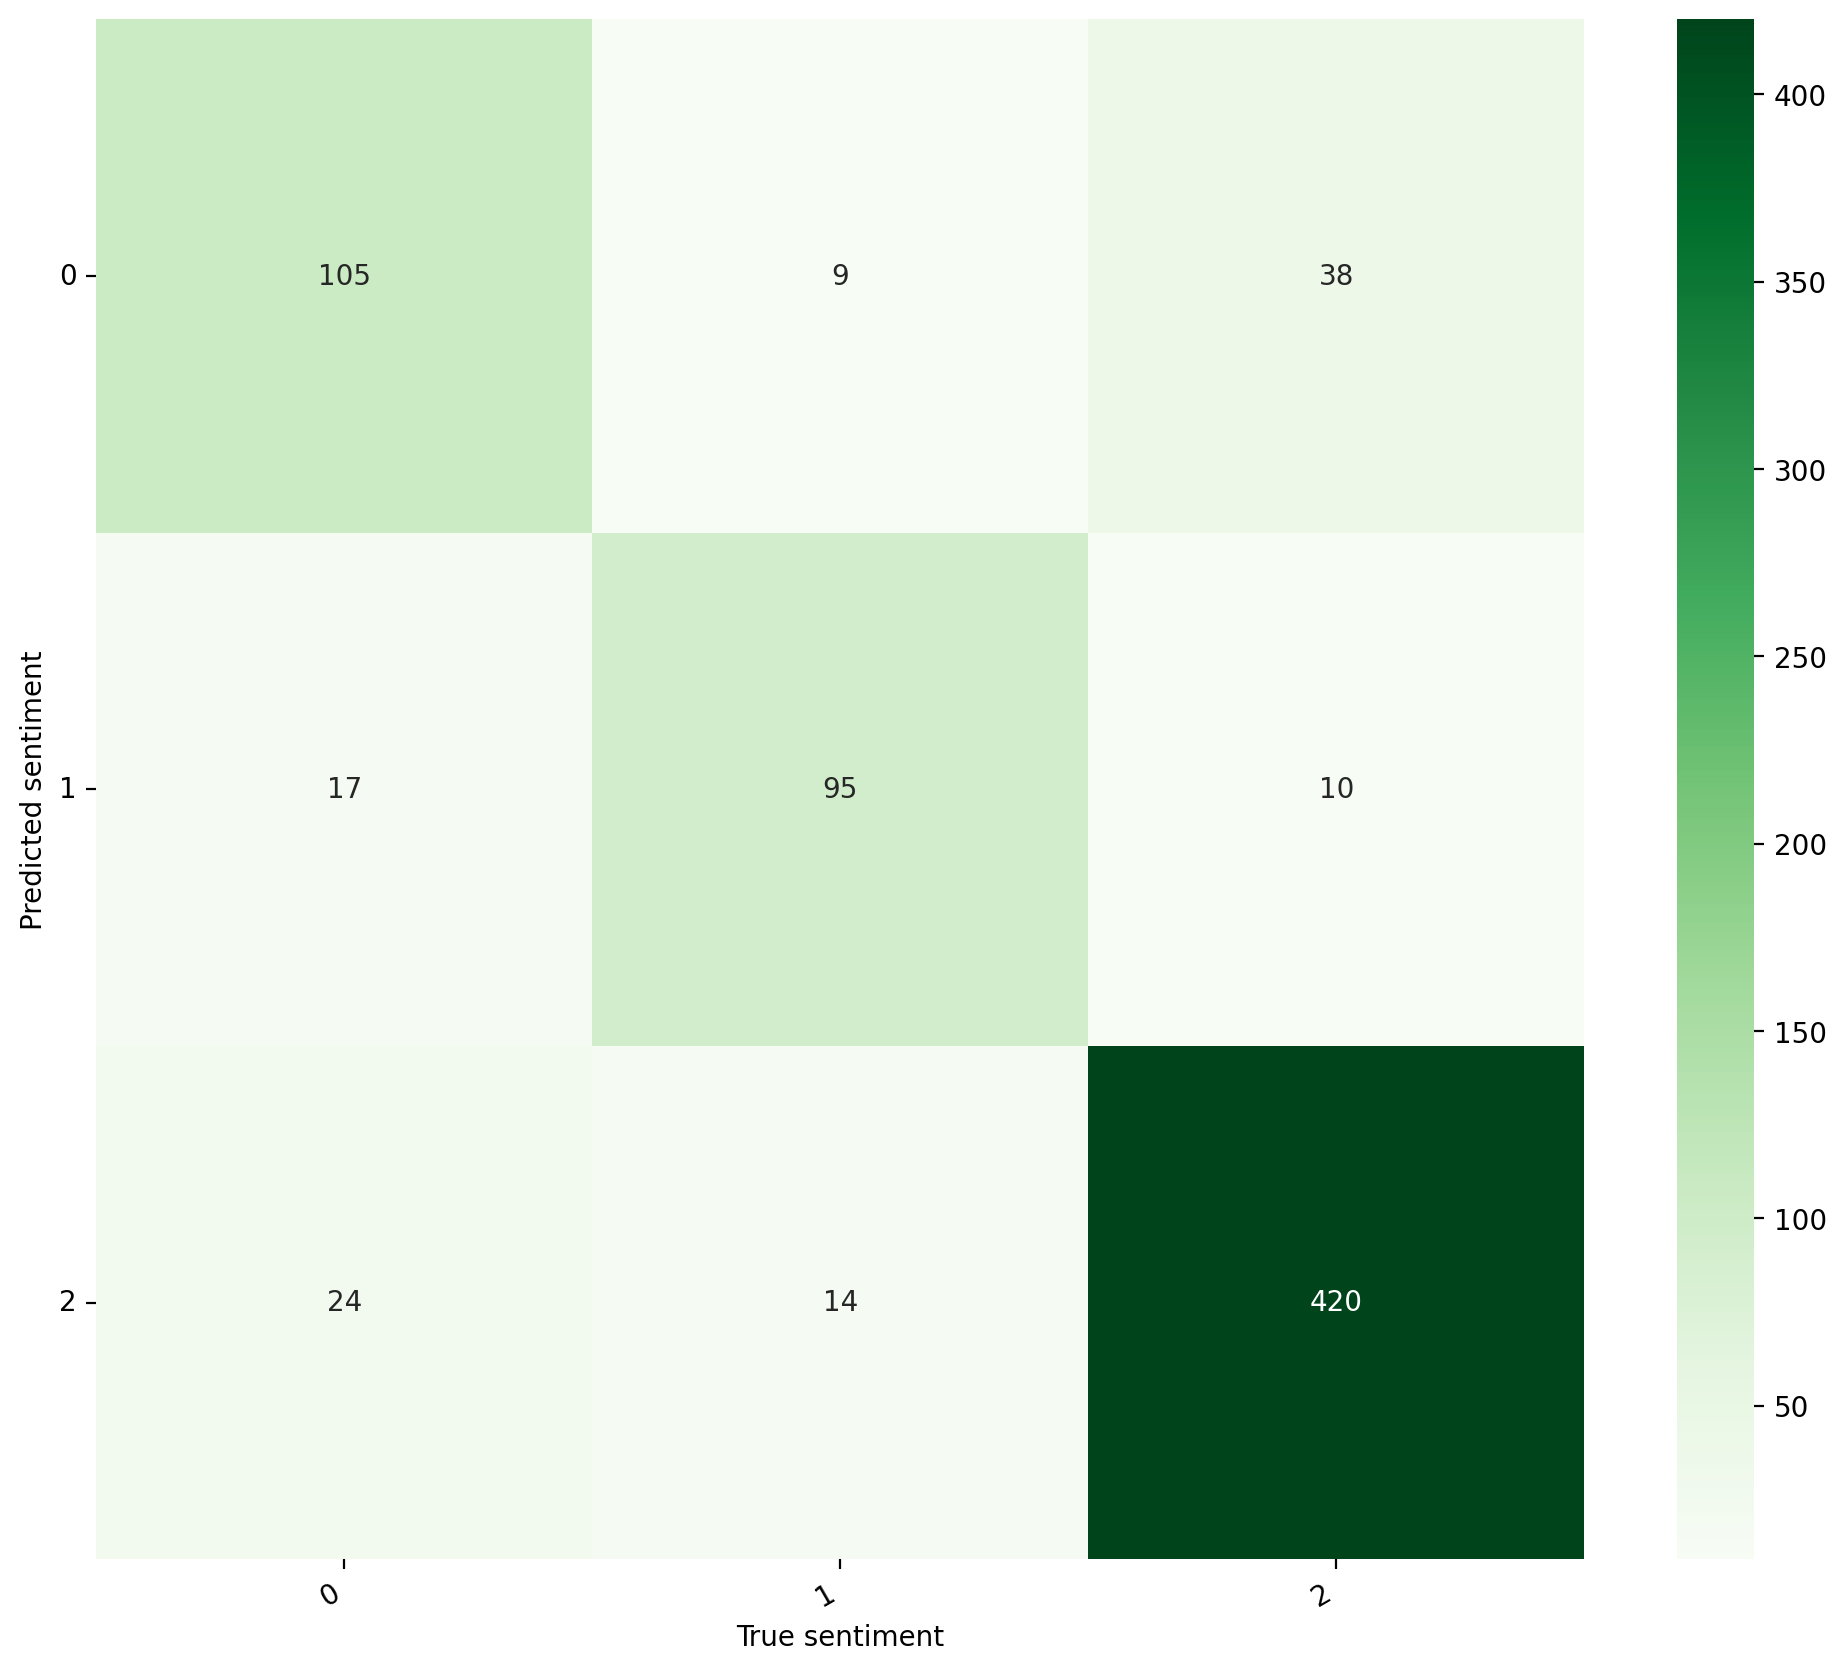

In [ ]:
cm = confusion_matrix(labels, predictions)
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.xlabel('True sentiment')
plt.ylabel('Predicted sentiment')

Metrics for positive tweets and neutral tweets are similar. It is also seen that, the model performs well in the case of negative tweets. We can conclude that it does an average job, also we cannot go entirely by accuracy when it comes to class imbalance.